# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer

Nesse projeto, temos duas bases de dados: uma com dados laboratoriais a respeito quantidade de E. Coli presente na água das praias de Chicago, Illinois, EUA e outra que mensura diferentes características físicas da água, ambas em diferentes datas e horários. 

Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros físicos utilizados para analisar a água. Faremos isso usando um modelo de regressão linear e analisando a correlação entre a concentração de bactérias e as diferentes variáveis físicas presentes na base de dados. 

A hipótese inicial (H0) é que as variáveis das características físicas da água têm correlação com a concentração de bactérias na água. Estatisticamente isso quer dizer que os betas na regressão linear são diferentes de zero, ou seja, que existe uma correlação. Portanto, nossa hipótese alternativa (H1) é de que as variáveis das características físicas da água não têm correlação com a concentração de bactérias na água, ou seja, que os betas na regressão linear são iguais a zero. 
Pretendemos confirmar ou rejeitar nossa hipótese inicial por meio da regressão linear e teste de hipóteses que será feito a seguir.


$$H_0: \beta_i\neq0$$  $$existe$$$$correlação$$




$$H_1: \beta_i=0$$ $$não$$ $$existe$$ $$correlação$$



In [1]:
#Importando diretórios

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import numpy as np
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score

C:\Users\steph\Anaconda3.0\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\steph\Anaconda3.0\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Abaixo fizemos as edições necessárias em nomes das células para conseguir fazer as alterações necessárias posteriormente para relacionar informações:

In [2]:
#Abrindo bases de dados
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

#Editando as colunas dos Data Frames

lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]
water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


#Selecionando as colunas do Date Frame 
lab = pd.DataFrame(lab.loc[:, ["Beach","ReadingMean","Sample1TimeStamp"]])
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity", "WaveHeight", "WavePeriod", "TimestampLabel"]])

#Editando e padronizando o nome das praias

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

#Padronizando data e hora do Data Frame de dados da água 

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

Nossa base de dados teve as colunas filtradas de acordo com as variáveis que julgamos necessárias para fazer nossa análise.
No caso da base de dados de dados laboratoriais, decidimos que só era importante para nós analisar a média, e o horário. A medição que usamos para fazer as análises nesse sentido é a Reading Mean, dada em CPU.
CFU- Colony-Forming Unit

Em microbiologia, a CFU é usada para estimar o número de células de bactérias ou fungos viáveis em uma amostra. Ser viável significa ser capaz de se multiplicar por meio de fissão binária (mitose).

Já para as características físicas da água, decidimos analisar a Turbidez, Temperatura, Período da Onda e Altura da Onda.

In [3]:
lab.head()

,Beach,ReadingMean,Sample1TimeStamp
0,NaN,239.3,2013-08-15
2,Hartigan,69.0,2010-06-02
5,Marion Mahony Griffin,7.1,2015-08-13
7,Marion Mahony Griffin,57.8,2007-08-17
8,Hartigan,10.8,2015-09-04


In [4]:
water.head()

,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,0.298,4.0,2014-05-28,Montrose


Para conseguir relacionar as informações das bases de dados, tivemos que usar o join. Precisávamos relacionar informações por meio de localização geográfica, ou seja, pelo nome da praia, e também pelo horário. Como precisávamos cruzar duas informações, usamos o módulo merge do pandas. 

In [5]:
#join e merge das duas bases de dados 

joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')

new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df=new_df.dropna()
new_df= pd.DataFrame(new_df.loc[:, ['Beach','ReadingMean','Sample1TimeStamp','WtrTemperature','Turbidity','WaveHeight','WavePeriod','TimestampLabel']])

new_df = new_df.loc[(new_df.WaveHeight != -99999.992)]

new_df.head()

,Beach,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel
629,Montrose,844.0,2016-08-05,22.7,0.0,0.093,4.0,2016-08-05
630,Montrose,844.0,2016-08-05,22.7,0.0,0.097,8.0,2016-08-05
631,Montrose,844.0,2016-08-05,22.7,0.0,0.097,7.0,2016-08-05
632,Montrose,844.0,2016-08-05,22.6,0.0,0.091,5.0,2016-08-05
633,Montrose,844.0,2016-08-05,22.6,0.0,0.101,10.0,2016-08-05


Abaixo estão plotados gráficos de dispersão que relacionam cada característica física da água, no eixo das abcissas, com a medição, em CFU, da quantidade de bactérias, nas ordenadas. Para cada gráfico fizemos um redimensionamento dos eixos, unicamente para melhorar a visualização dos pontos plotados no gráfico.

## Dispersão/Correlação da Variavel Y em função das Variáveis Independentes 

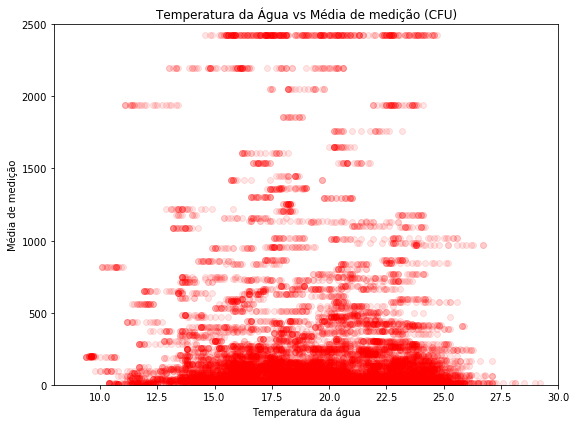

In [21]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WtrTemperature, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('Temperatura da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Temperatura da água')


plt.tight_layout()
plt.axis([8,30,0,2500,])
plt.show()

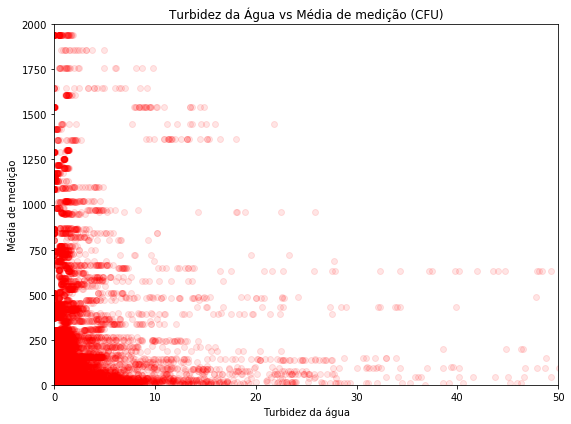

In [37]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.Turbidity, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Turbidez da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Turbidez da água')


plt.tight_layout()
plt.axis([0,50,0,2000])
plt.show()

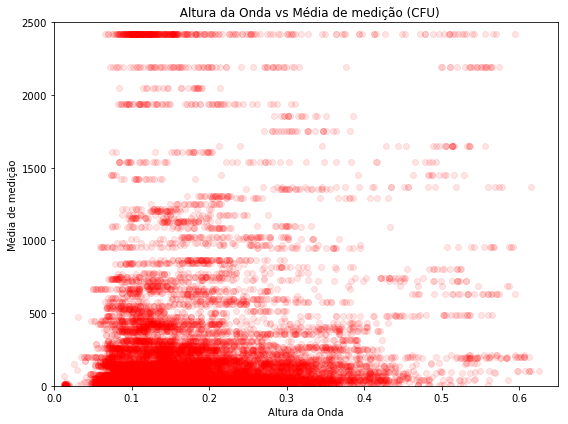

In [8]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WaveHeight, new_df.ReadingMean, c='red', alpha=0.1)
plt.title('  Altura da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Altura da Onda')
plt.axis([0,0.65,0,2500])

plt.tight_layout()
plt.show()

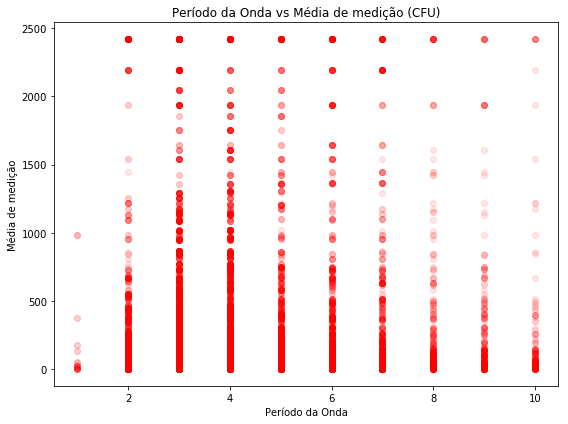

In [9]:
#plotagem gráfico

fig = plt.figure(figsize=(8, 6))
plt.scatter(new_df.WavePeriod, new_df.ReadingMean,  c='red', alpha=0.1)
plt.title('Período da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Período da Onda')


plt.tight_layout()
plt.show()

Analisando os gráficos qualitativamente, é possível concluir que nenhuma das variáveis físicas plotadas parece ter relação com a concentração de bactérias na água, pelo menos não em duas dimensões. Ainda assim, para confirmar se podemos ou nao rejeitar H0, que indica que as variáveis das características físicas da água têm correlação com a concentração de bactérias na água, vamos fazer um modelo de regressão linear.

## Regressão Linear


Vamos usar a função OLS() da biblioteca statsmodel

In [10]:
#rodando função OLS() da biblioteca statsmodel

Y = new_df['ReadingMean']
X = new_df[['WtrTemperature','Turbidity','WaveHeight','WavePeriod']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ReadingMean   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     120.8
Date:                Sun, 19 Nov 2017   Prob (F-statistic):          5.90e-102
Time:                        15:45:24   Log-Likelihood:            -1.3975e+05
No. Observations:               18556   AIC:                         2.795e+05
Df Residuals:                   18551   BIC:                         2.795e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            110.1474     22.709      4.850      0.000      65.635     154.660
WtrTemperature    -3.3543      0.966     -3.473      0.001      -5.247      -1.461
Turbidity         -0.5415      0.103     -5.276      0.000      -0.743      -0.340
WaveHeight       659.9825     36.089     18.288      0.000     589.245     730.721
WavePeriod        18.3985      2.048      8.984      0.000      14.384      22.413
==============================================================================
Omnibus:                    12753.923   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           141522.956
Skew:                           3.330   Prob(JB):                         0.00
Kurtosis:                      14.777   Cond. No.                         371.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Os resultados da nossa regressão linear, extraídos da tabela, podem ser vistos abaixo:

$$\beta_0 = 110.1474$$

$$\beta_1 = -3.3543$$

$$\beta_2 = -0.5415$$

$$\beta_3 = 659.9825$$

$$\beta_4 = 18.3985$$

Analisando esses valores, é possível perceber que nenhum vale exatamente 0, ou seja, nenhum nos leva a rejeitar H0 logo de cara, mas será necessário fazer um teste de hipótese para ver se os valores próximos de zero devem ser rejeitados por serem muito improváveis de ocorrer, ou se  não devem ser rejeitados, indicando que existe correlação entre a variável Y e a variável independende relacionada a esse Beta em questão. Vamos fazer esse teste de hipótese considerando um alfa de 5%.

Abaixo estão listados, extraídos da tabela, o valor-p de cada Beta, e os limites superior e inferior (valores críticos) para um alfa de 5%:

#### Beta 0: 110.1474

Valor-p: 0.000

Limite Inferior: 65.635

Limite Superior: 154.660

#### Beta 1: -3.3543

Valor-p: 0.001

Limite Inferior: -5.247	

Limite Superior: -1.461

#### Beta 2: -0.5415

Valor-p: 0.000

Limite Inferior: -0.743

Limite Superior: -0.340

#### Beta 3: 659.9825

Valor-p: 0.000

Limite Inferior: 589.245

Limite Superior: 730.721

#### Beta 4: 18.3985

Valor-p: 0.000

Limite Inferior: 14.384

Limite Superior: 22.413

Além dos resultados obtidos pelos valores críticos e valores-p, analisando os resultados, percebe-se que não foi possível fazer uma modelagem correta de regressão linear. A curva normal gerada é muito anormal, tendo as medidas "Skew" e "Kurtosis" muito alteradas, mostrando inconsistência. 

Skew é uma medida de assimetria. Com um valor de 3,330 indica uma "cauda" assimétrica com valores positivos, à direita, ou seja, com uma cauda maior para a direita. A distribuição normal ideal tem Skew = 0, e tem valores distribuídos igualmente à direita e à esquerda.

Kurtosis, por sua vez, é uma medida que indica a deformação do pico da distribuição. Com Kurtosis = 14.777, percebe-se que o pico da distribuição está muito mais elevado do que deveria estar em uma normal.


Ademais, para confirmar a falha gerada pelo modelo normal, é possível verificar como distribuem-se as variáveis. De acordo com o Teorema do Limite Central, para um número n de amostras significativamente grande, a distribuição das amostras se aproxima da normal. Temos um n significativamente grande em nossas amostras, mas nem sempre elas não se acomodaram como uma normal: 



## Distribuição das Variáveis Independentes

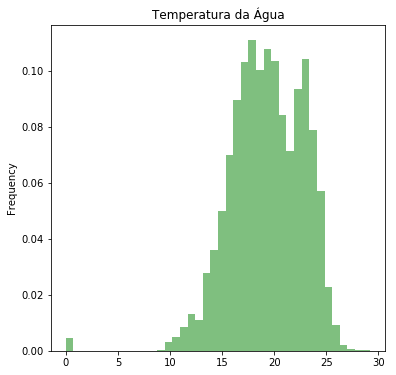

In [11]:
#plotagem gráficos

new_df.WtrTemperature.plot.hist(bins=40,title='Temperatura da Água', figsize=(6, 6), normed=1, alpha=0.5, color='g')


[0, 35, 0, 0.45]

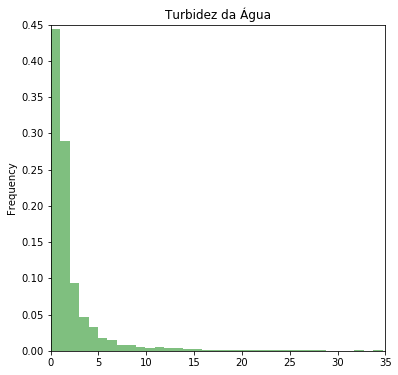

In [12]:
#plotagem gráficos

new_df.Turbidity.plot.hist(bins=1200,title='Turbidez da Água',figsize=(6, 6), normed=1, alpha=0.5, color='g')
plt.axis([0,35,0,0.45])

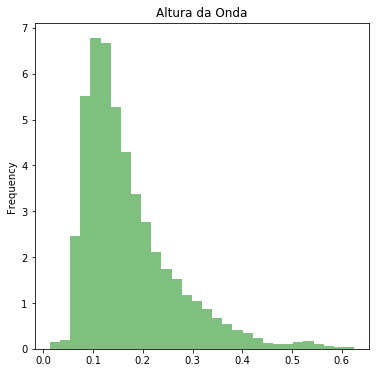

In [13]:
#plotagem gráficos

new_df.WaveHeight.plot.hist(bins=30,title='Altura da Onda',figsize=(6, 6), normed=1, alpha=0.5, color='g')

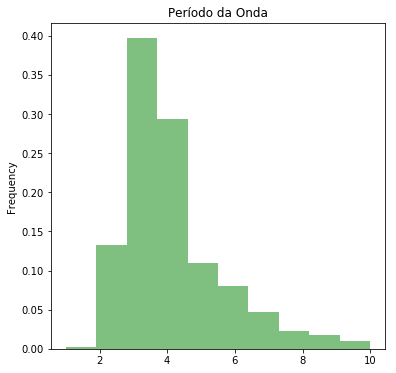

In [14]:
#plotagem gráficos

new_df.WavePeriod.plot.hist(title='Período da Onda',figsize=(6, 6), normed=1, alpha=0.5, color='g')

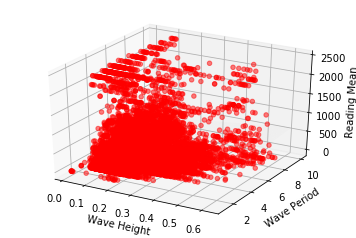

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
model = smf.ols(formula='ReadingMean ~ WaveHeight + WavePeriod', data=new_df)
results_formula = model.fit()
results_formula.params




x_surf, y_surf = np.meshgrid(np.linspace(new_df.WaveHeight.min(), new_df.WaveHeight.max(), 100),np.linspace(new_df.WavePeriod.min(), new_df.WavePeriod.max(), 100))
onlyX = pd.DataFrame({'WaveHeight': x_surf.ravel(), 'WavePeriod': y_surf.ravel()})
fittedY=results_formula.predict(exog=onlyX)


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_df['WaveHeight'],new_df['WavePeriod'],new_df['ReadingMean'],c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.values.reshape(x_surf.shape), color='None', alpha=0.01)
ax.set_xlabel('Wave Height')
ax.set_ylabel('Wave Period')
ax.set_zlabel('Reading Mean')
plt.show()

Percebe-se que nenhuma das distribuições acomoda-se bem numa normal. Por conta disso, a regressão linear não é um modelo adequado para modelar as informações das nossas bases de dados. Uma segunda técnica de análise será abordada: uma Árvore de Decisão de Regressão.


## Árvore de Decisão

In [15]:
new_df.head(2)

,Beach,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,WaveHeight,WavePeriod,TimestampLabel
629,Montrose,844.0,2016-08-05,22.7,0.0,0.093,4.0,2016-08-05
630,Montrose,844.0,2016-08-05,22.7,0.0,0.097,8.0,2016-08-05


In [16]:
X = new_df.iloc[:,3:6]
y = new_df.iloc[:,1]

X_train, X_test, y_train, y_test = train_test_split(X, y)




X_train, X_test, y_train, y_test = train_test_split(X, y, 
test_size=0.20, random_state=0)

dt = DecisionTreeRegressor(random_state=0, criterion="mae")
dt_fit = dt.fit(X_train, y_train)

dt_scores = cross_val_score(dt_fit, X_train, y_train, cv = 5)
print("mean cross validation score: {}".format(np.mean(dt_scores)))
print("score without cv: {}".format(dt_fit.score(X_train, y_train)))

# on the test or hold-out set
from sklearn.metrics import r2_score
print(r2_score(y_test, dt_fit.predict(X_test)))
print(dt_fit.score(X_test, y_test))

mean cross validation score: -0.7501529421513319
score without cv: 0.9961676555369445
-0.507135042132
-0.507135042132
